<a href="https://colab.research.google.com/github/mhayes30125/cloud-developer/blob/master/Final_02_finetune_Wav2Vec2_to_Hubert_CC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 123.7 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.1
    Uninstalling transformers-4.51.1:
      Successfully uninstalled transformers-4.51.1


In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
from tqdm import tqdm

import torchaudio

import os
import sys

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Apr 16 11:30:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [4]:
%%capture
!pip install transformers
!pip install datasets

In [5]:
%%capture
!sudo apt-get install git-lfs


In [6]:
%%capture
!git lfs install
!--system
!--skip-repo

In [7]:
from huggingface_hub import notebook_login

notebook_login()

In [8]:
data_path =  Path('/content/drive/My Drive/Neural Network and Deep Learning/Project/final_data')

In [9]:
input_col = 'path'
output_col = 'label'
audio_len = 32
num_classes = 5
label_list = []

In [23]:
from sklearn.model_selection import train_test_split
from typing import Tuple, List

def get_data(filename: str)-> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    df_all = pd.read_csv(filename)

    # The original data had 2 classes: dementia, no dementia. Because
    # we know have 5 classes, no dementia is grossly over represented, so
    # I am removing some to make the portions between the classes more
    # balanced.
    df_no_aug = df_all[df_all['is_aug'] == 0]
    df_no_dementia = df_no_aug[df_no_aug['label'] == 'no dementia']
    df_other_labels = df_no_aug[df_no_aug['label'] != 'no dementia']
    df_no_dementia_100 = df_no_dementia.head(40) #(250)
    df_all = pd.concat([df_no_dementia_100, df_other_labels])

    # df_all = df_all[df_all['is_aug'] == 0]
    # Spliting data into train and test set.
    # Note: stratify makes sure that both train and test maintain the same class distribution
    # Note: random_state makes sure that the row shuffle is done the same way for repeatability
    df_train_plus_valid, df_test = train_test_split(df_all, test_size=0.25, stratify=df_all["label"], random_state=42)
    df_train, df_valid = train_test_split(df_train_plus_valid, test_size=0.25,stratify=df_train_plus_valid["label"], random_state=42)

    print(f"Number of classes: {len(label_list)}")
    print(f"Classes: {label_list}")
    return df_all, df_train, df_test, df_valid

In [24]:
df_all, df_train, df_test, df_valid = get_data(os.path.join(data_path, 'train_dm.csv'))
label_list = df_all[output_col].unique().tolist()
label_list.sort()

Number of classes: 5
Classes: ['fifteen years to dementia', 'five years to dementia', 'no dementia', 'ten years to dementia', 'zero years to dementia']


In [25]:
import torch

df_train_counts = df_train["label"].value_counts()
print("Label counts")
print(df_train_counts)

df_test_counts = df_test["label"].value_counts()
print("Label counts")
print(df_test_counts)

df_valid_counts = df_valid["label"].value_counts()
print("Label counts")
print(df_valid_counts)
#class_weights = 1.0 / class_counts
#print("Inverse frequency")
#print(class_weights)
#class_weights = class_weights / class_weights.sum()
#print("Normalize to sum to 1")
#print(class_weights)
#class_weights = torch.tensor(class_weights.values, dtype=torch.float32)
#print("Convert to tensor")
#print(class_weights)

Label counts
label
five years to dementia       25
no dementia                  22
ten years to dementia        18
zero years to dementia       16
fifteen years to dementia    15
Name: count, dtype: int64
Label counts
label
five years to dementia       11
no dementia                  10
ten years to dementia         8
zero years to dementia        7
fifteen years to dementia     7
Name: count, dtype: int64
Label counts
label
five years to dementia       8
no dementia                  8
ten years to dementia        6
zero years to dementia       5
fifteen years to dementia    5
Name: count, dtype: int64


In [26]:
repo_name = "hubert-base-ls960-aug"
model_name = "facebook/hubert-base-ls960" # using this model because I was having memory issues
pooling_mode = "mean"

In [27]:
from transformers.models.hubert import HubertConfig
from transformers.models.wav2vec2 import Wav2Vec2Processor, Wav2Vec2FeatureExtractor

In [28]:
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name,)
target_sampling_rate = feature_extractor.sampling_rate
print(f"The target sampling rate: {target_sampling_rate}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/213 [00:00<?, ?B/s]

The target sampling rate: 16000


In [29]:
from random import randint

def random_subsample(wav: np.ndarray, max_length: float, sample_rate: int = 16000):
    """Randomly sample chunks of `max_length` seconds from the input audio"""
    sample_length = int(round(sample_rate * max_length))
    if len(wav) <= sample_length:
        return wav
    random_offset = randint(0, len(wav) - sample_length - 1)
    return wav[random_offset : random_offset + sample_length]

def speech_to_array(path):
    speech, sr = torchaudio.load(path)
    transform = torchaudio.transforms.Resample(sr, 16000)
    speech = transform(speech)[0].numpy().squeeze()
    #return random_subsample(speech, max_length=audio_len)
    return speech


def label_to_id(label, label_list):
    if len(label_list) > 0:
        return label_list.index(label) if label in label_list else -1
    return label

def preprocess_fn(examples):
    speech_list = [speech_to_array(path) for path in examples[input_col]]
    target_list = [label_to_id(label, label_list) for label in examples[output_col]]
    # 320250/16000 = 20 seconds of audio
    result = feature_extractor(speech_list, sampling_rate=target_sampling_rate, return_tensors="pt", padding="max_length", truncation=True,max_length=320250 )
    result['temp_label'] = list(target_list)

    return result


In [30]:
from datasets import Dataset

train_data = Dataset.from_pandas(df_train)
test_data = Dataset.from_pandas(df_test)

train_data = train_data.map(preprocess_fn, batch_size=8, batched=True, num_proc=4,)
test_data = test_data.map(preprocess_fn, batch_size=8, batched=True, num_proc=4,)

Map (num_proc=4):   0%|          | 0/96 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/43 [00:00<?, ? examples/s]

In [31]:
print(train_data.column_names)

['label', 'name', 'path', 'is_aug', '__index_level_0__', 'input_values', 'temp_label']


In [32]:
#rename the label column which is a string for display purposes.
# the label colum is used internally and is expected to be a numberical value
train_data = train_data.remove_columns("label")
train_data = train_data.remove_columns("name")
train_data = train_data.remove_columns("path")
train_data = train_data.remove_columns("is_aug")
train_data = train_data.remove_columns("__index_level_0__")
train_data = train_data.rename_column("temp_label", "label")

test_data = test_data.remove_columns("label")
test_data = test_data.remove_columns("name")
test_data = test_data.remove_columns("path")
test_data = test_data.remove_columns("is_aug")
test_data = test_data.remove_columns("__index_level_0__")
test_data = test_data.rename_column("temp_label", "label")

In [33]:
unique_labels = train_data.unique("label")
print(unique_labels)
unique_labels = test_data.unique("label")
print(unique_labels)
print(train_data.column_names)

[1, 0, 3, 4, 2]
[4, 1, 2, 3, 0]
['input_values', 'label']


In [60]:
from transformers.models.hubert import HubertConfig
from transformers.models.hubert import HubertModel
import torch.nn as nn
import torch

class HuBERTClassifier(nn.Module):
    def __init__(self, model_name=model_name, num_labels=num_classes):
        super().__init__()
        self.hubert = HubertModel.from_pretrained(model_name)
        self.hubert.gradient_checkpointing_enable()
        self.config = self.hubert.config
        self.classifier = nn.Sequential(
            nn.Linear(self.hubert.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_labels)
        )

    def forward(self, input_values, attention_mask=None, labels=None):
        outputs = self.hubert(input_values, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state.mean(dim=1)
        logits = self.classifier(pooled)

        loss = None
        if labels is not None:
            #class_weights_tensor = class_weights.to(labels.device)
            #loss_fct = nn.CrossEntropyLoss(weight=class_weights_tensor)
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)

        return {"loss": loss, "logits": logits}

In [61]:
import numpy as np
from transformers.trainer_utils import EvalPrediction
from sklearn.metrics import accuracy_score

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.argmax(preds, axis=1)

    # return {'accuracy': (preds == p.label_ids).astype(np.float32).mean().item()}
    accuracy = accuracy_score(p.label_ids, preds)

    return {"accuracy": accuracy}

In [62]:
device = torch.device("cuda") # if torch.cuda.is_available() else "cpu")
model = HuBERTClassifier().to(device)

In [63]:
from transformers.trainer import Trainer
from transformers.training_args import TrainingArguments

model_path = "./hubert-custom"

training_args = TrainingArguments(
    output_dir= model_path,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    eval_strategy="steps",
    save_steps=100,
    eval_steps=100,
    logging_steps=100,
    learning_rate=3e-5,
    num_train_epochs=6,
    fp16=True,  # Mixed precision
    save_total_limit=2,
    remove_unused_columns=False,  # Keep inputs for custom model
)




In [64]:
from transformers.trainer import Trainer
import numpy as np

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_data,
    eval_dataset=test_data,
)

In [65]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
100,1.587200,1.596702,0.232558


TrainOutput(global_step=144, training_loss=1.5745713975694444, metrics={'train_runtime': 134.3321, 'train_samples_per_second': 4.288, 'train_steps_per_second': 1.072, 'total_flos': 0.0, 'train_loss': 1.5745713975694444, 'epoch': 6.0})

In [66]:
trainer.push_to_hub(repo_name)

events.out.tfevents.1744804004.3f178e2c26e6.2256.3:   0%|          | 0.00/5.09k [00:00<?, ?B/s]

events.out.tfevents.1744803551.3f178e2c26e6.2256.0:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

events.out.tfevents.1744803894.3f178e2c26e6.2256.2:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

events.out.tfevents.1744803828.3f178e2c26e6.2256.1:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

Upload 8 LFS files:   0%|          | 0/8 [00:00<?, ?it/s]

events.out.tfevents.1744804830.3f178e2c26e6.2256.4:   0%|          | 0.00/5.09k [00:00<?, ?B/s]

events.out.tfevents.1744805336.3f178e2c26e6.2256.5:   0%|          | 0.00/6.76k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/mhayes/hubert-custom/commit/a8af416bc2d9cb67f8f0a8aa4e4accfc224c21e2', commit_message='hubert-base-ls960-aug', commit_description='', oid='a8af416bc2d9cb67f8f0a8aa4e4accfc224c21e2', pr_url=None, repo_url=RepoUrl('https://huggingface.co/mhayes/hubert-custom', endpoint='https://huggingface.co', repo_type='model', repo_id='mhayes/hubert-custom'), pr_revision=None, pr_num=None)

In [68]:
from transformers.models.auto.modeling_auto import AutoModelForSequenceClassification
from transformers.models.wav2vec2 import Wav2Vec2Processor, Wav2Vec2FeatureExtractor
device = torch.device("cuda")
#model_name is interal in my custom HuBERTClassifier and needs to be set
mode_name = "mhayes/hubert-custom"
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
model = HuBERTClassifier()
#model.load_state_dict(torch.load(os.path.join(model_path, "pytorch_model.bin")))
model.to(device)
model.eval()

HuBERTClassifier(
  (hubert): HubertModel(
    (feature_extractor): HubertFeatureEncoder(
      (conv_layers): ModuleList(
        (0): HubertGroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x HubertNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x HubertNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): HubertFeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): HubertEnco

In [69]:

def speech_to_array_predict(batch):
    speech_list = []
    for path in batch["path"]:
        speech, sr = torchaudio.load(path)
        transform = torchaudio.transforms.Resample(sr, 16000)
        speech = transform(speech)[0].numpy().squeeze()
        speech_list.append(speech)
    batch["speech"] = speech_list

    return batch

def predict(batch):
    features = feature_extractor(batch["speech"], sampling_rate=feature_extractor.sampling_rate, return_tensors="pt", padding=True)

    with torch.no_grad():
        input_values = features.input_values.to(device)
        outputs = model(input_values)
        logits = outputs["logits"]
        pred_ids = torch.argmax(logits, dim=-1).detach().cpu().numpy()
        batch["predicted"] = pred_ids
        return batch

In [70]:
valid_data = Dataset.from_pandas(df_valid)
valid_data = valid_data.map(speech_to_array_predict, batch_size=4, batched=True, num_proc=1,)


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

In [71]:
results = valid_data.map(predict, batch_size=8, batched=True, num_proc=1,)

Parameter 'function'=<function predict at 0x7ad47c445620> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

In [72]:
y_true = [label_list.index(name) for name in results["label"]]
y_pred = results["predicted"]

y_true_labels = results["label"]
y_pred_labels = [label_list[id] for id in y_pred]

#print(y_true)
#print(y_pred)

#for i in range(len(y_true)):
#    if y_pred_labels[i] == y_true_labels[i]:
#        print(f"{y_true_labels[i]} -> {y_pred_labels[i]}")

from sklearn.metrics import accuracy_score

accuracy_score(y_true, y_pred)

0.09375

In [73]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_true_labels, y_pred_labels, labels=label_list)

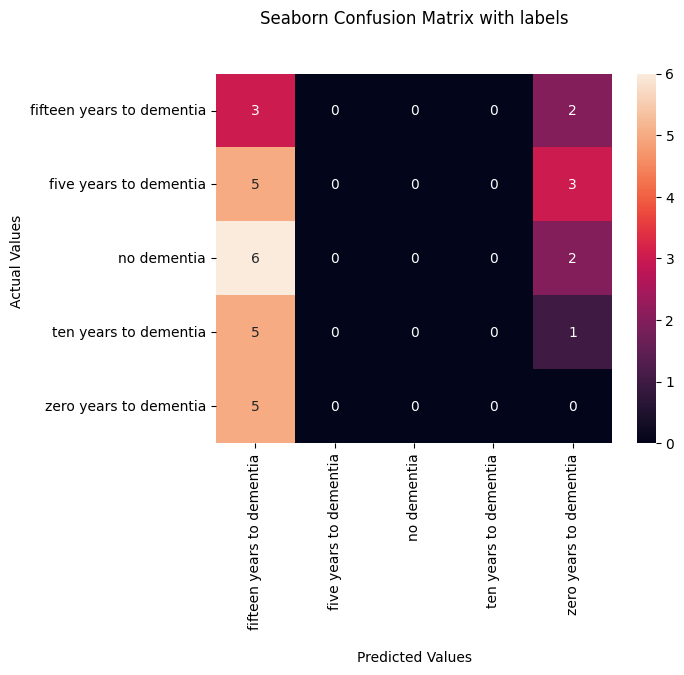

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib_inline as mpl

cm = pd.DataFrame(cf_matrix, index = [i for i in label_list], columns = [i for i in label_list])
ax = sns.heatmap(cm, annot=True)

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Display the visualization of the Confusion Matrix.
plt.show()

In [75]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=label_list))

                           precision    recall  f1-score   support

fifteen years to dementia       0.12      0.60      0.21         5
   five years to dementia       0.00      0.00      0.00         8
              no dementia       0.00      0.00      0.00         8
    ten years to dementia       0.00      0.00      0.00         6
   zero years to dementia       0.00      0.00      0.00         5

                 accuracy                           0.09        32
                macro avg       0.03      0.12      0.04        32
             weighted avg       0.02      0.09      0.03        32



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
